In [3]:
import os
import numpy as np
import pandas as pd
import pickle
import sys
sys.path.append('/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages')
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
# plt.rcParams['figure.dpi'] = 300

### 1. Get directories related information and load in MoonBoard 2016 data

In [4]:
cwd = os.getcwd() # /preprocessing
parent_wd = cwd.replace('/preprocessing', '')
raw_data_path = parent_wd + '/raw_data/moonGen_scrape_2016_final'

# hold_feature_path = parent_wd + '/raw_data/HoldFeature2016.xlsx'

In [5]:
img_wd = parent_wd + '/images'
mb_2016_img_path = img_wd + '/mb_2016_img.jpeg'

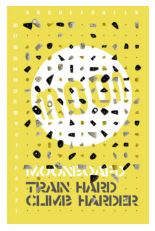

In [6]:
mb_2016_img = cv2.imread(mb_2016_img_path)
cv2.imshow("image", mb_2016_img)
plt.imshow(cv2.cvtColor(mb_2016_img, cv2.COLOR_BGR2RGB))
# plt.gcf().set_dpi(300)
plt.axis('off')
# plt.grid(alpha=0.2)
plt.show()

In [7]:
def get_coor(hold):
    x, y = hold
    x_coor = 94 + x*51
    y_coor = 958 - y*51
    return (int(x_coor), int(y_coor))

def display_hold(hold):
    img = mb_2016_img.copy()
    center = get_coor(hold)
    cv2.circle(img = img, center=center, radius =30, color =(255,0,0), thickness=5)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.gcf().set_dpi(150)
    plt.axis('off')
    plt.show()

circle_color = {
    'start': (0,255,0),
    'mid': (255,0,0),
    'end': (0,0,255),
}

def add_hold(hold, img, hold_type):
    center = get_coor(hold)
    c = circle_color[hold_type]
    cv2.circle(img = img, center = center, radius = 28, color = c, thickness=5)

def display_route(route):
    img = mb_2016_img.copy()
    for key, item in route.items():
        for hold in item:
            add_hold(hold, img, key)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.gcf().set_dpi(150)
    plt.axis('off')
    plt.show()

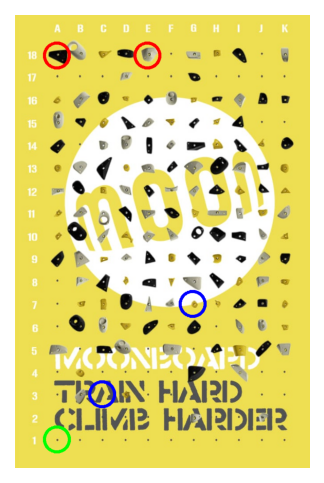

In [8]:
r = {'start': [[0,0]], 'mid': [[2,2], [6,6]], 'end': [[0,17],[4,17]]}
display_route(r)

In [9]:
with open(raw_data_path, 'rb') as f:
    MoonBoard_2016_raw = pickle.load(f)
print('Number of routes after scraping:', len(MoonBoard_2016_raw))

Number of routes after scraping: 30642


In [10]:
#for keys in MoonBoard_2016_raw:
#    print(keys, '=>', MoonBoard_2016_raw[keys])

In [11]:
def get_grade_map():
    """
    Defines a mapping of Fontainebleau grades to integer values
    """
    grade_map = {
        '6B': 0,  # V4
        '6B+': 0, # V4
        '6C': 1,  # V5
        '6C+': 1, # V5
        '7A': 2,  # V6
        '7A+': 3, # V7
        '7B': 4,  # V8
        '7B+': 4, # V8
        '7C': 5,  # V9
        '7C+': 6, # V10
        '8A': 7,  # V11
        '8A+': 8, # V12
        '8B': 9,  # V13
    }
    return grade_map

grade_map = get_grade_map()
print(grade_map)

{'6B': 0, '6B+': 0, '6C': 1, '6C+': 1, '7A': 2, '7A+': 3, '7B': 4, '7B+': 4, '7C': 5, '7C+': 6, '8A': 7, '8A+': 8, '8B': 9}


In [12]:
# clean

mb_2016 = {}
fields = ['start', 'mid', 'end', 'grade', 'user_grade', 'is_benchmark', 'repeats', 'url']
legal_routes = []

for key, item in MoonBoard_2016_raw.items():
    if (item['grade'] in grade_map) and (item['user_grade'] in grade_map or item['user_grade']==None) and (len(item['start']) <= 2) and (len(item['end']) <= 2) and (item['repeats'] > 0):
        legal_routes.append(key)

for key in legal_routes:
    mb_2016[key] = {}
    for f in fields:
        mb_2016[key][f] = MoonBoard_2016_raw[key][f]
    for f in ['grade', 'user_grade']:
        if mb_2016[key][f] != None:
            mb_2016[key][f] = grade_map[mb_2016[key][f]]

print('Number of routes after cleaning: ', len(mb_2016))

Number of routes after cleaning:  25099


In [13]:
all_grades = []
for key, item in mb_2016.items():
    all_grades.append(item['grade'] + 4)

all_grades_count = []
all_grades_percentages = []
for i in range(4, 14):
    n = all_grades.count(i)
    all_grades_count.append(n)
    all_grades_percentages.append(n*100/len(all_grades))

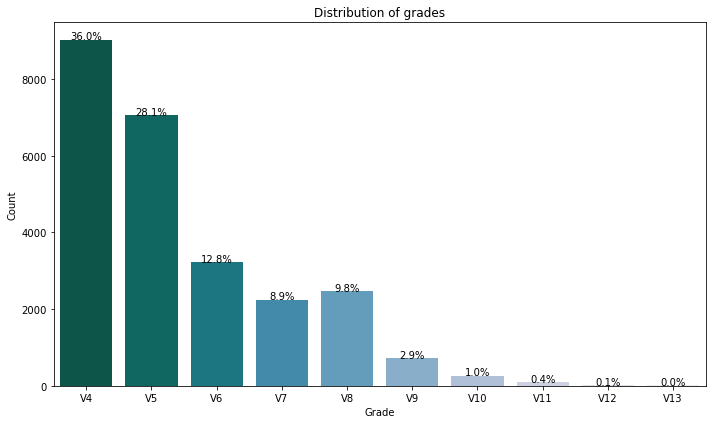

In [14]:
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True
x = ['V' + str(grade) for grade in range(4, 14)]
y = all_grades_count
percentage = all_grades_percentages
ax = sns.barplot(x=x, y=y, palette='PuBuGn_r')
ax.set(xlabel='Grade', ylabel='Count', title = 'Distribution of grades')
patches = ax.patches
for i in range(len(patches)):
   x = patches[i].get_x() + patches[i].get_width()/2
   y = patches[i].get_height()+10
   ax.annotate('{:.1f}%'.format(percentage[i]), (x, y), ha='center')
plt.show()

In [15]:
# hold types is a list of combination of 'start', 'mid', 'end'

def get_holds(item, hold_types):
    route = []
    for t in hold_types:
        for hold in item[t]:
            route.append(hold)
    return route

def convert_matrix(list):
    matrix = np.zeros((11,18))
    for hold in list:
        x = hold[0]
        y = hold[1]
        matrix[x][y] = 1
    return matrix

def display_matrix(matrix):
    return np.flip(matrix.T, 0)

def get_matrices(data, hold_types):
    d = {}
    l = []
    for key in data:
        route = get_holds(data[key], hold_types)
        d[key] = display_matrix(convert_matrix(route))
        l.append(display_matrix(convert_matrix(route)))
    return d, l

def heat_matrix(data, grades_list):
    d = {}
    for key, item in data.items():
        if item['grade'] in grades_list:
            d[key] = item
    matrix_list = get_matrices(d, ['mid'])[1]
    return sum(matrix_list)/len(matrix_list)

In [16]:
    plt.figure(figsize=(9, 10))
    sns.set(font_scale=2)
    x_list = ['A','B','C','D','E','F','G','H','I','J','K']
    ax = sns.heatmap(heat_all, linewidth=5, xticklabels = x_list, yticklabels = range(18, 0, -1), cmap="Blues", square = True)
    v_grades_list = [grade + 4 for grade in grades_list]
    plt.title('Hold Frequency in Grade ' + 'V'+', V'.join(map(str, v_grades_list)))
    plt.show()

NameError: name 'heat_all' is not defined

<Figure size 648x720 with 0 Axes>

In [17]:
x = [*range(0,10)]
print(x)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [18]:
mb_2016_grades = {}
for key in mb_2016:
    mb_2016_grades[key] = mb_2016[key]['grade']

In [19]:
mb_2016_matrices, all_matrices = get_matrices(mb_2016, ['mid'])

In [20]:
heat_all = heat_matrix(mb_2016, [*range(0,10)])
heat_v4_5 = heat_matrix(mb_2016, [0, 1])
heat_v6_9 = heat_matrix(mb_2016, [2, 3, 4, 5])
heat_v10_13= heat_matrix(mb_2016, [6, 7, 8, 9])

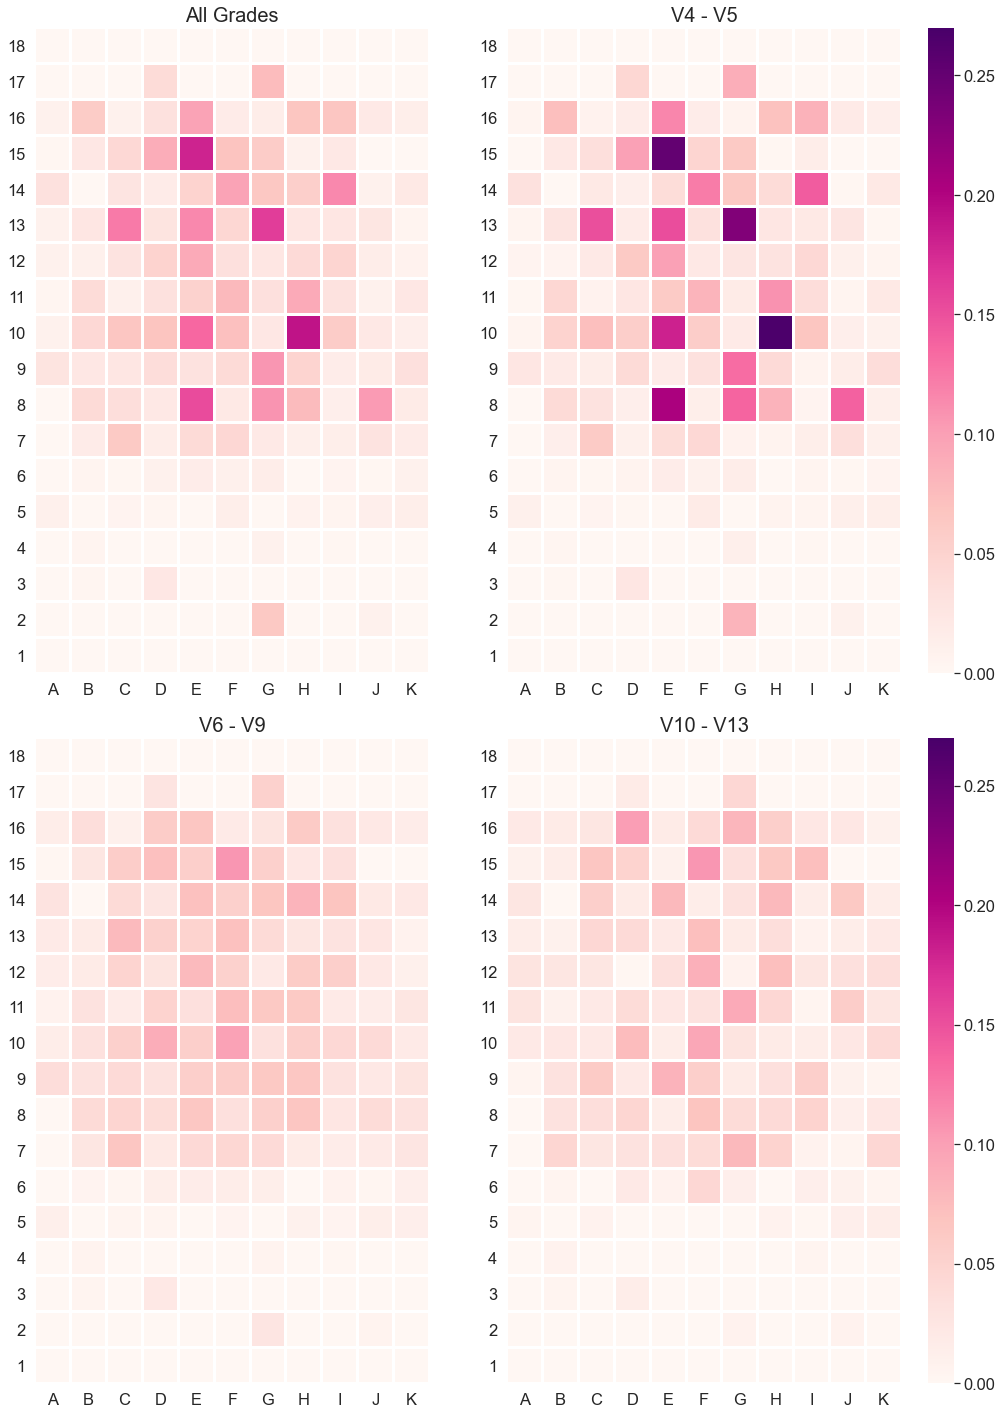

In [21]:
fig = plt.figure(figsize=(15, 20))
sns.set(font_scale=1.5)

x_list = ['A','B','C','D','E','F','G','H','I','J','K']

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

sns.heatmap(heat_all, ax=ax1, linewidth=2, xticklabels = x_list, cmap="RdPu", square = True, vmin=0, vmax=0.27, cbar=False)
sns.heatmap(heat_v4_5, ax=ax2, linewidth=2, xticklabels = x_list, cmap="RdPu", square = True, vmin=0, vmax=0.27, cbar_kws={"aspect": 25})
sns.heatmap(heat_v6_9, ax=ax3, linewidth=2, xticklabels = x_list, cmap="RdPu", square = True, vmin=0, vmax=0.27, cbar=False)
sns.heatmap(heat_v10_13, ax=ax4, linewidth=2, xticklabels = x_list, cmap="RdPu", square = True, vmin=0, vmax=0.27, cbar_kws={"aspect": 25})

ax1.set_yticklabels(range(18, 0, -1),rotation=0)
ax2.set_yticklabels(range(18, 0, -1),rotation=0)
ax3.set_yticklabels(range(18, 0, -1),rotation=0)
ax4.set_yticklabels(range(18, 0, -1),rotation=0)

ax1.set_title('All Grades', fontsize=20)
ax2.set_title('V4 - V5', fontsize=20)
ax3.set_title('V6 - V9', fontsize=20)
ax4.set_title('V10 - V13', fontsize=20)

plt.show()

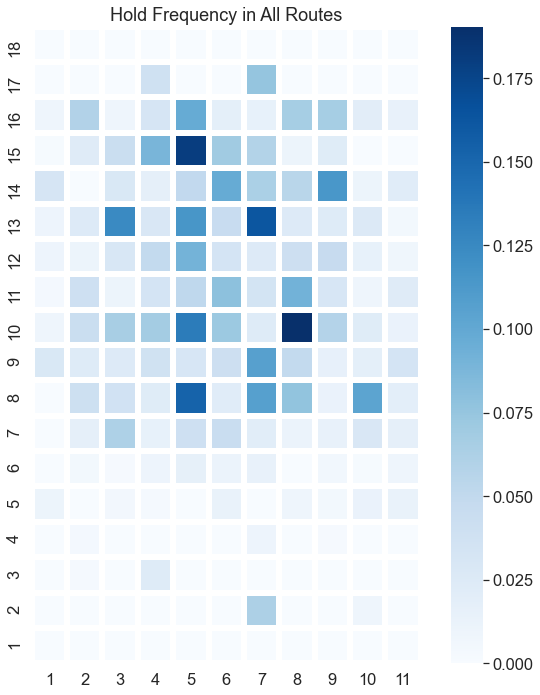

In [22]:
heat_all = heat_matrix(mb_2016, [*range(0,10)])
heat_v4 = heat_matrix(mb_2016, [0])

plt.figure(figsize=(9, 10))
sns.set(font_scale=1.5)
ax = sns.heatmap(heat_all, linewidth=5, xticklabels = range(1, 12), yticklabels = range(18, 0, -1), cmap="Blues", square = True)
plt.title('Hold Frequency in All Routes')
plt.show()

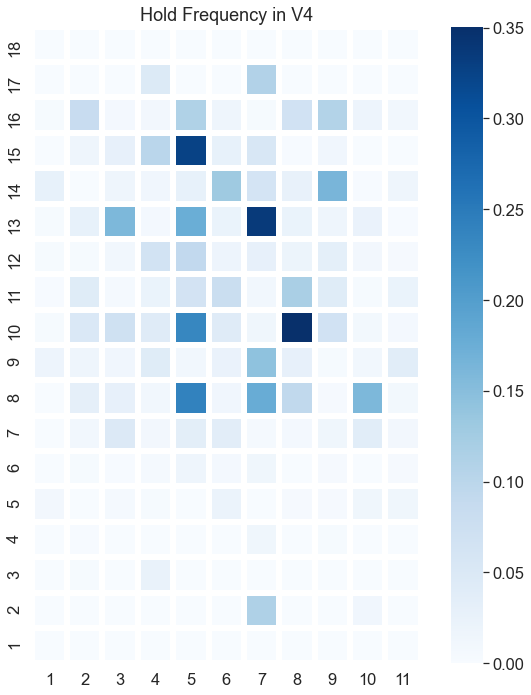

In [23]:
plt.figure(figsize=(9, 10))
sns.set(font_scale=1.5)
ax = sns.heatmap(heat_v4, linewidth=5, xticklabels = range(1, 12), yticklabels = range(18, 0, -1), cmap="Blues", square = True)
plt.title('Hold Frequency in V4')
plt.show()

In [24]:
mb_2016_matrices, all_matrices = get_matrices(mb_2016, ['mid'])

In [25]:
def get_matrices(data, hold_types):
    d = {}
    l = []
    for key in data:
        route = get_holds(data[key], hold_types)
        d[key] = display_matrix(convert_matrix(route))
        l.append(display_matrix(convert_matrix(route)))
    return d, l

def heat_matrix(data, grades_list):
    d = {}
    for key, item in data.items():
        if item['grade'] in grades_list:
            d[key] = item
    matrix_list = get_matrices(d, ['mid'])[1]
    return sum(matrix_list)/len(matrix_list)

In [26]:
mb_2016_grades = {}
for key in mb_2016:
    mb_2016_grades[key] = mb_2016[key]['grade']

In [27]:
import random
samples = {}

for item in random.sample(list(mb_2016.items()), 25000):
    samples[item[0]] = item[1]

In [28]:
sample_matrices = get_matrices(samples, ['start','mid','end'])[0]

In [29]:
print(len(sample_matrices))

25000


In [30]:
# reshaped
sample_vectors = {}
for i in sample_matrices:
    sample_vectors[i] = np.array(sample_matrices[i]).reshape(1, 198)

In [31]:
sample_grades = {}
for key in samples:
    sample_grades[key] = mb_2016[key]['grade']

In [32]:
sample_grades_list = list(sample_grades.values())
sample_vectors_list = list(sample_vectors.values())

sample_data = []

for i in range(len(sample_grades_list)):
    sample_data.append([])
    
    vector = sample_vectors_list[i][0]
    grade = sample_grades_list[i]
    for j in range(11*18):
        sample_data[i].append(vector[j])
    sample_data[i].append(grade)

In [33]:
sample_df = pd.DataFrame(sample_data)
sample_df

,0,1,2,3,4,5,6,7,8,9,...,189,190,191,192,193,194,195,196,197,198
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
24996,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
24997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
24998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [34]:
X = sample_df.iloc[:, :-1]
y = sample_df.iloc[:, -1]

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
import seaborn as sns

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# define functions we need for cross validation and assessing model accuracy

def cross_val(model, k):
  """
  Perform kfold cross validation and print results.
  ---
  Inputs:
  - model: trained classification model
  - k: number of splits/iterations
  """
  # kfold cross validation with k splits
  cv = KFold(n_splits=k, random_state=1, shuffle=True)
  scores = cross_val_score(model, X, y, cv=cv)

  # scatterplot of cross validation scores and mean score
  x = range(k)
  plt.scatter(x, scores)
  plt.axhline(y=np.mean(scores), color = 'red')
  plt.title('k-fold cross validation results')
  plt.xlabel('CV iteration')
  plt.ylabel('Accuracy')
  plt.ylim([0, 1.1])
  print('\n')
  plt.show()
  print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

def metrics(actual, predicted):
  """
  Print classification report and confusion matrix for the results of a classification model.
  ---
  Inputs:
  - actual: list of actual y values
  - predicted: list of predicted y values
  """
  print("\nClassification report:\n" + classification_report(actual, predicted, zero_division = 0))
  print("\nConfusion matrix:")
  cm = confusion_matrix(y_test, log_predicted)
  ax = plt.axes()
  sns.heatmap(cm, annot=True, annot_kws={"size": 7}, fmt='d',cmap="Blues", ax = ax )
  ax.set_title('Confusion Matrix')
  plt.show()

Model: Logistic Regression

Classification report:
              precision    recall  f1-score   support

           0       0.70      0.75      0.72      1787
           1       0.39      0.55      0.46      1372
           2       0.26      0.12      0.16       629
           3       0.31      0.10      0.16       486
           4       0.35      0.47      0.40       513
           5       0.27      0.08      0.13       144
           6       0.25      0.02      0.04        45
           7       0.00      0.00      0.00        18
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         2

    accuracy                           0.49      5000
   macro avg       0.25      0.21      0.21      5000
weighted avg       0.47      0.49      0.47      5000


Confusion matrix:


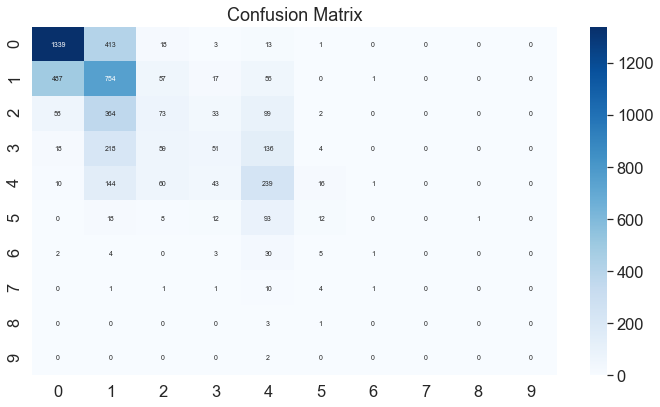

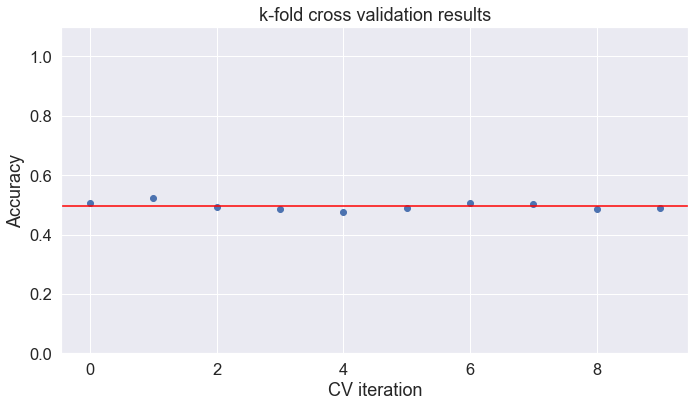

0.50 accuracy with a standard deviation of 0.01


In [38]:
# logistic regression classifier

log_classifier = LogisticRegression(random_state = 0, max_iter=3000)
log_classifier.fit(X_train, y_train)
log_predicted = log_classifier.predict(X_test)

print("Model: Logistic Regression")

# k = 37 (number of total images) for leave one out cross validation
#cross_val(log_classifier, len(images))
metrics(y_test, log_predicted)
cross_val(log_classifier, 10)

Model: Naive Bayes

Classification report:
              precision    recall  f1-score   support

           0       0.58      0.64      0.61      1792
           1       0.41      0.21      0.27      1411
           2       0.20      0.09      0.13       664
           3       0.15      0.07      0.09       435
           4       0.19      0.04      0.07       476
           5       0.09      0.06      0.07       137
           6       0.05      0.19      0.08        57
           7       0.01      0.70      0.02        23
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         2

    accuracy                           0.32      5000
   macro avg       0.17      0.20      0.13      5000
weighted avg       0.38      0.32      0.33      5000


Confusion matrix:


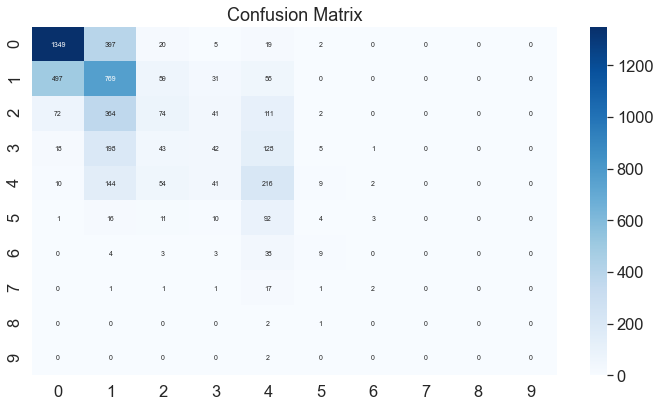

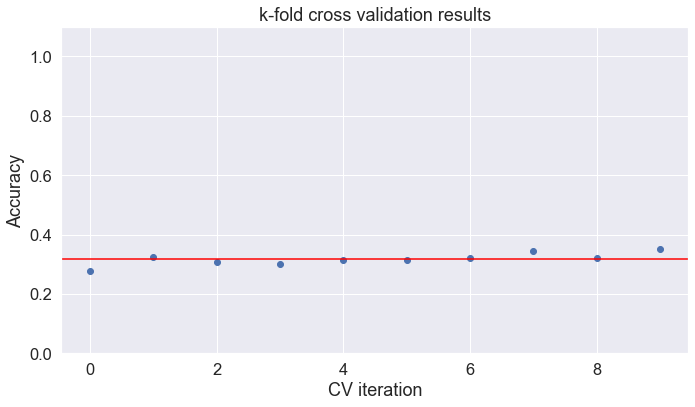

0.32 accuracy with a standard deviation of 0.02


In [35]:
# naive bayes

nb = GaussianNB()
nb_predicted = nb.fit(X_train, y_train).predict(X_test)

print("Model: Naive Bayes")
metrics(y_test, nb_predicted)
cross_val(nb, 10)

Model: Random Forest

Classification report:
              precision    recall  f1-score   support

           0       0.37      1.00      0.54      1787
           1       0.17      0.02      0.03      1372
           2       0.00      0.00      0.00       629
           3       0.00      0.00      0.00       486
           4       0.00      0.00      0.00       513
           5       0.00      0.00      0.00       144
           6       0.00      0.00      0.00        45
           7       0.00      0.00      0.00        18
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         2

    accuracy                           0.36      5000
   macro avg       0.05      0.10      0.06      5000
weighted avg       0.18      0.36      0.20      5000


Confusion matrix:


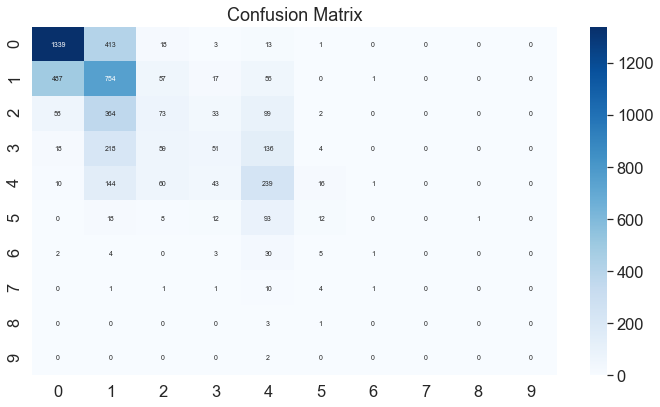

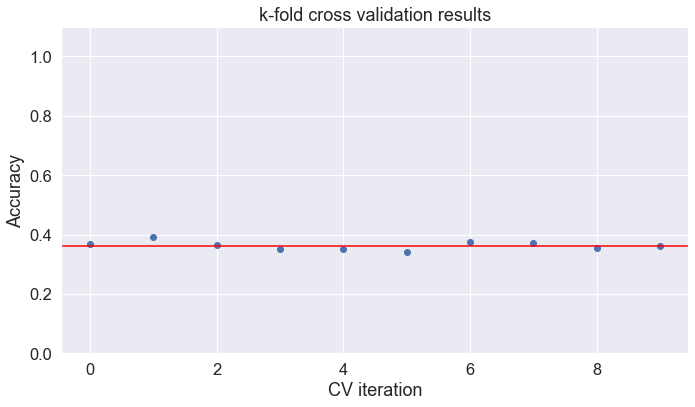

0.36 accuracy with a standard deviation of 0.01


In [41]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=2, random_state=0)
rf_predicted = rf.fit(X_train, y_train).predict(X_test)

print("Model: Random Forest")
metrics(y_test, rf_predicted)
cross_val(rf, 10)

Model: XGBoost

Classification report:
              precision    recall  f1-score   support

           0       0.70      0.75      0.72      1787
           1       0.38      0.56      0.46      1372
           2       0.27      0.09      0.14       629
           3       0.30      0.12      0.17       486
           4       0.36      0.39      0.37       513
           5       0.27      0.10      0.15       144
           6       0.04      0.02      0.03        45
           7       0.00      0.00      0.00        18
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         2

    accuracy                           0.49      5000
   macro avg       0.23      0.20      0.20      5000
weighted avg       0.46      0.49      0.46      5000


Confusion matrix:


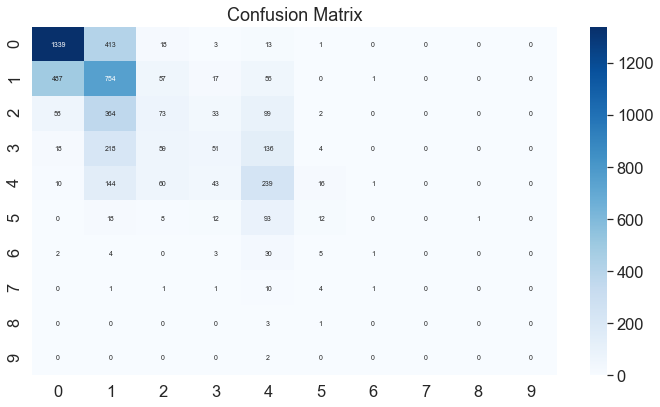

In [42]:
from sklearn.ensemble import HistGradientBoostingClassifier

xgboost = HistGradientBoostingClassifier()
xgboost_predicted = xgboost.fit(X_train, y_train).predict(X_test)

print("Model: XGBoost")
metrics(y_test, xgboost_predicted)
#cross_val(xgboost, 10)

In [1]:
# next steps:

# softmax, 